<a href="https://colab.research.google.com/github/chokun7788/PoopforAIB/blob/main/SaveThisForGood!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# กำหนด path ของข้อมูล
train_dir = "/content/drive/MyDrive/dataset/train"
valid_dir = "/content/drive/MyDrive/dataset/valid"
test_dir = "/content/drive/MyDrive/dataset/test"

# เตรียม Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# โหลดข้อมูลจากโฟลเดอร์ train, valid, test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# สร้างโมเดลโดยใช้ Pre-trained ResNet50 (ปิดใช้งาน fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze บาง layers ของ ResNet50 (ทำการ fine-tune)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Unfreeze 10 layers สุดท้าย
    layer.trainable = False

# สร้างโมเดลใหม่
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # ป้องกัน overfitting
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # ปรับเป็นจำนวน class ที่ต้องการ
])

# ใช้ optimizer ด้วย learning rate ที่ต่ำ
optimizer = Adam(learning_rate=1e-5)

# คอมไพล์โมเดล
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ใช้ EarlyStopping เพื่อหยุดการฝึกเมื่อไม่เห็นการปรับปรุงใน validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ใช้ ModelCheckpoint เพื่อบันทึกโมเดลที่ดีที่สุด (การประเมินโดย validation accuracy)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/dataset/retailclass/my_best_model.h5', monitor='val_loss', save_best_only=True)

# ฝึกโมเดล
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping, checkpoint]
)

# โหลดโมเดลที่ดีที่สุด
best_model = models.load_model('/content/drive/MyDrive/dataset/retailclass/my_best_model.h5')

# ประเมินผลบนชุดข้อมูล test
test_loss, test_acc = best_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# คำนวณ F1 score และค่าประเมินอื่นๆ
from sklearn.metrics import classification_report
import numpy as np

# ทำนายผลลัพธ์จาก test set
y_pred = best_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# แปลงค่าที่ทำนายให้เป็น class index โดยการเลือก class ที่มีความน่าจะเป็นสูงสุด
y_pred_classes = np.argmax(y_pred, axis=1)

# ดึง label จริงจาก test set
y_true = test_generator.classes

# คำนวณ F1 score และค่าประเมินอื่นๆ
report = classification_report(y_true, y_pred_classes)
print(report)


Found 3347 images belonging to 6 classes.
Found 418 images belonging to 6 classes.
Found 423 images belonging to 6 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3866 - loss: 1.5279

104/104 ━━━━━━━━━━━━━━━━━━━━ 1171s 11s/step - accuracy: 0.3871 - loss: 1.5268 - val_accuracy: 0.3510 - val_loss: 1.5167
Epoch 2/20
  1/104 ━━━━━━━━━━━━━━━━━━━━ 13:54 8s/step - accuracy: 0.4688 - loss: 1.2718

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


104/104 ━━━━━━━━━━━━━━━━━━━━ 98s 875ms/step - accuracy: 0.4688 - loss: 1.2718 - val_accuracy: 0.3486 - val_loss: 1.5225
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5035 - loss: 1.2951

104/104 ━━━━━━━━━━━━━━━━━━━━ 920s 9s/step - accuracy: 0.5036 - loss: 1.2951 - val_accuracy: 0.3462 - val_loss: 1.4237
Epoch 4/20
  1/104 ━━━━━━━━━━━━━━━━━━━━ 13:53 8s/step - accuracy: 0.6875 - loss: 0.9998

104/104 ━━━━━━━━━━━━━━━━━━━━ 106s 952ms/step - accuracy: 0.6875 - loss: 0.9998 - val_accuracy: 0.3486 - val_loss: 1.4147
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5481 - loss: 1.2727

104/104 ━━━━━━━━━━━━━━━━━━━━ 918s 9s/step - accuracy: 0.5482 - loss: 1.2723 - val_accuracy: 0.4038 - val_loss: 1.3014
Epoch 6/20
  1/104 ━━━━━━━━━━━━━━━━━━━━ 10:45 6s/step - accuracy: 0.6875 - loss: 0.9067

104/104 ━━━━━━━━━━━━━━━━━━━━ 96s 867ms/step - accuracy: 0.6875 - loss: 0.9067 - val_accuracy: 0.4231 - val_loss: 1.2939
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5662 - loss: 1.1861

104/104 ━━━━━━━━━━━━━━━━━━━━ 917s 9s/step - accuracy: 0.5661 - loss: 1.1862 - val_accuracy: 0.5240 - val_loss: 1.2415
Epoch 8/20
  1/104 ━━━━━━━━━━━━━━━━━━━━ 13:52 8s/step - accuracy: 0.5625 - loss: 1.1893

104/104 ━━━━━━━━━━━━━━━━━━━━ 99s 885ms/step - accuracy: 0.5625 - loss: 1.1893 - val_accuracy: 0.5240 - val_loss: 1.2379
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5747 - loss: 1.1881

104/104 ━━━━━━━━━━━━━━━━━━━━ 943s 9s/step - accuracy: 0.5748 - loss: 1.1878 - val_accuracy: 0.5385 - val_loss: 1.1875
Epoch 10/20
  1/104 ━━━━━━━━━━━━━━━━━━━━ 11:28 7s/step - accuracy: 0.5625 - loss: 1.0711

104/104 ━━━━━━━━━━━━━━━━━━━━ 106s 963ms/step - accuracy: 0.5625 - loss: 1.0711 - val_accuracy: 0.5433 - val_loss: 1.1864
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5989 - loss: 1.1139

104/104 ━━━━━━━━━━━━━━━━━━━━ 931s 9s/step - accuracy: 0.5989 - loss: 1.1140 - val_accuracy: 0.5697 - val_loss: 1.1574
Epoch 12/20
  1/104 ━━━━━━━━━━━━━━━━━━━━ 10:20 6s/step - accuracy: 0.6250 - loss: 0.9911

104/104 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6250 - loss: 0.9911 - val_accuracy: 0.5769 - val_loss: 1.1533
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 948s 9s/step - accuracy: 0.5984 - loss: 1.0870 - val_accuracy: 0.5745 - val_loss: 1.1953
Epoch 14/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6875 - loss: 0.8732 - val_accuracy: 0.5745 - val_loss: 1.1885
Epoch 15/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 920s 9s/step - accuracy: 0.6005 - loss: 1.1133 - val_accuracy: 0.5361 - val_loss: 1.2534
Epoch 16/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 91s 811ms/step - accuracy: 0.7812 - loss: 0.6774 - val_accuracy: 0.5433 - val_loss: 1.2320
Epoch 17/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 922s 9s/step - accuracy: 0.6247 - loss: 1.0499 - val_accuracy: 0.5361 - val_loss: 1.2616


13/13 ━━━━━━━━━━━━━━━━━━━━ 155s 11s/step - accuracy: 0.5642 - loss: 1.1035
Test Accuracy: 57.21%
14/14 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.36      0.28      0.31       146
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        19
           4       0.42      0.69      0.52       182
           5       0.17      0.02      0.04        44

    accuracy                           0.40       423
   macro avg       0.16      0.17      0.15       423
weighted avg       0.32      0.40      0.34       423



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [2]:
# เซฟโมเดลที่ดีที่สุดไปยังโฟลเดอร์ SaveModel
model.save('/content/drive/MyDrive/SaveModel/my_best_model.h5')

In [3]:
# โหลดโมเดลจากไฟล์ที่บันทึกไว้
best_model = models.load_model('/content/drive/MyDrive/SaveModel/my_best_model.h5')

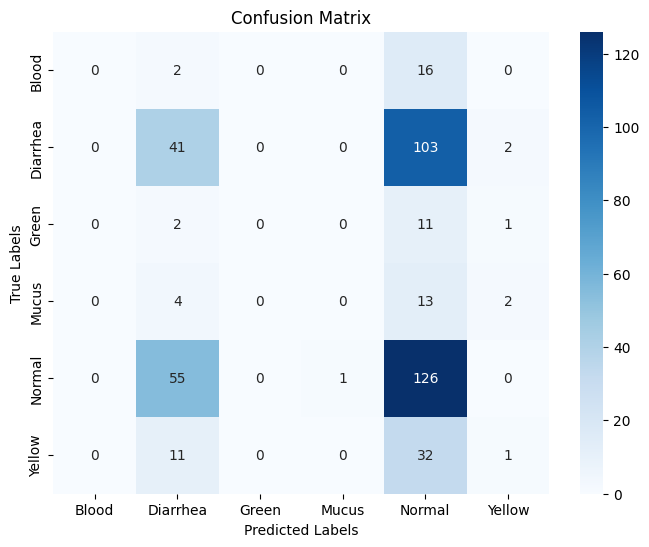

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# แสดงผลด้วย heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


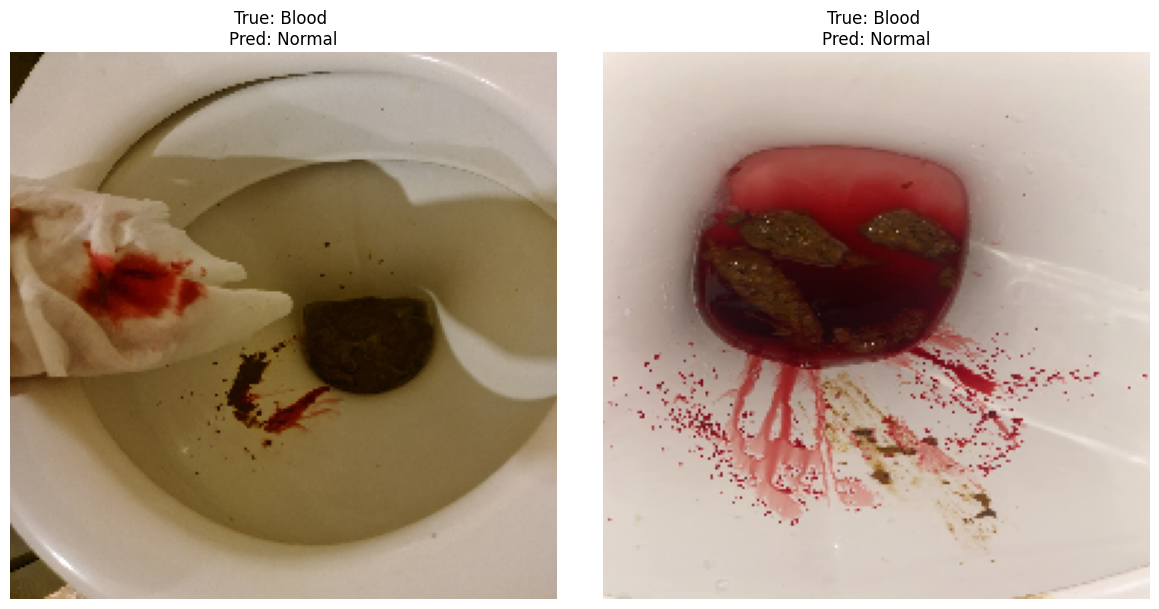

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


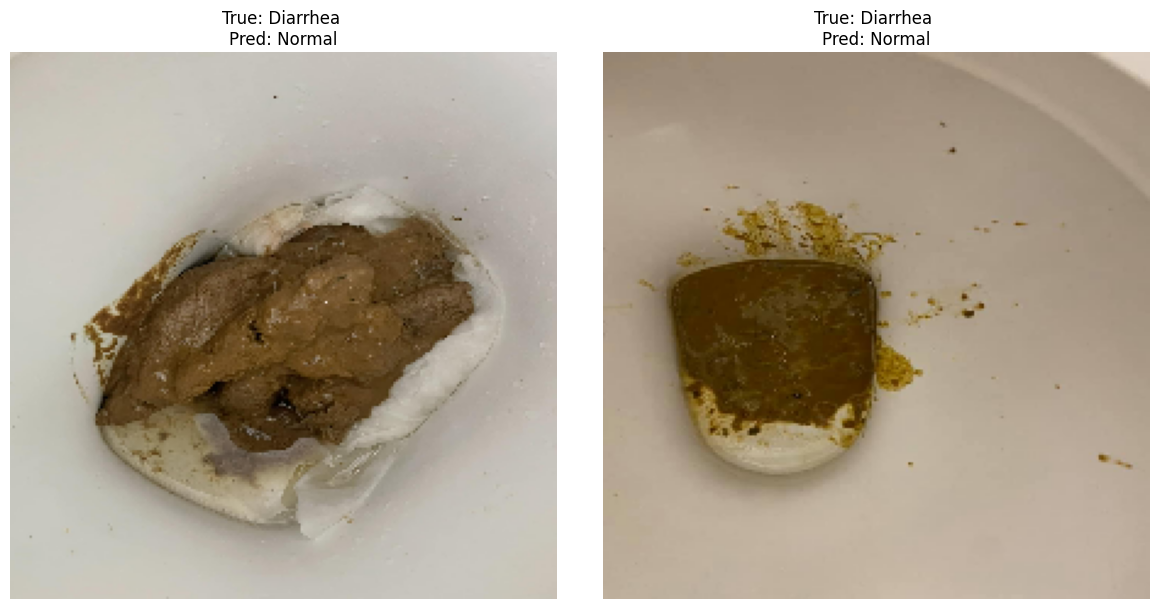

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


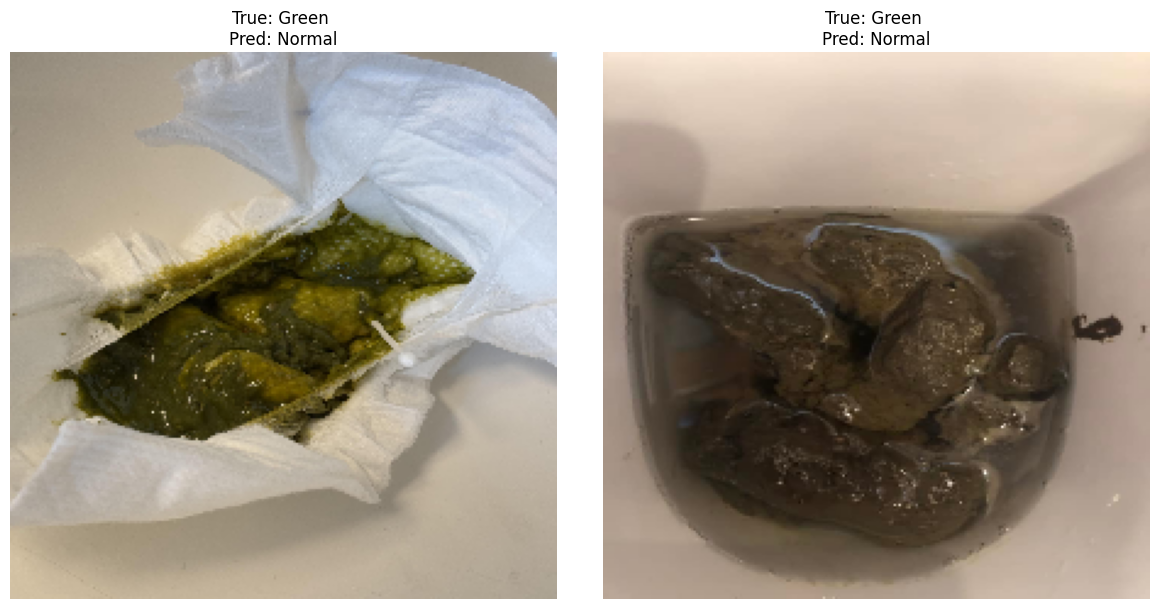

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


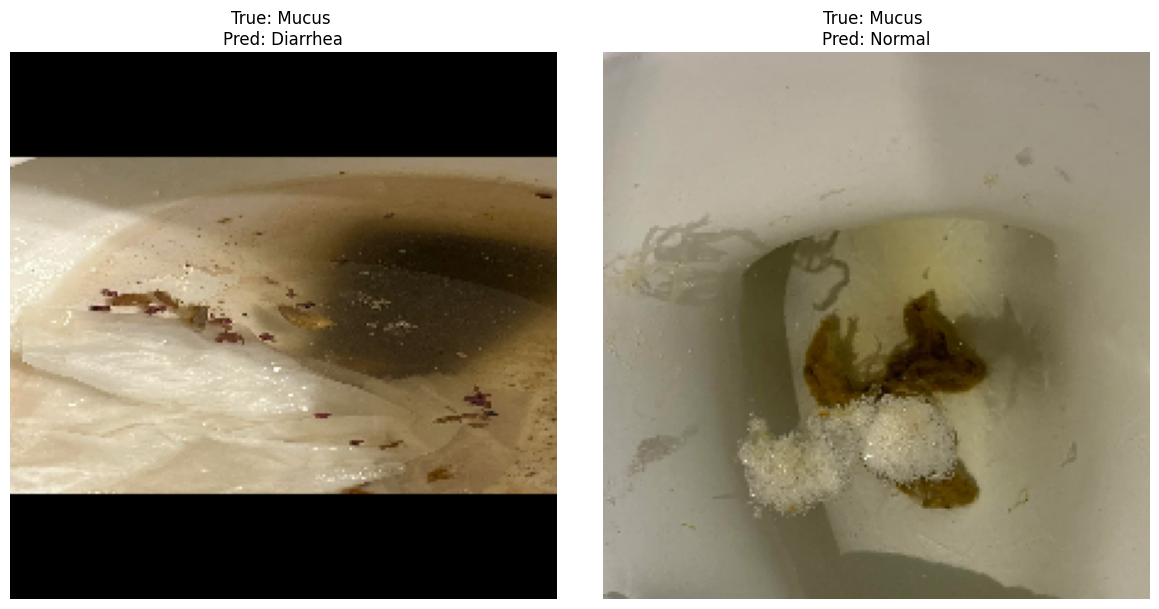

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


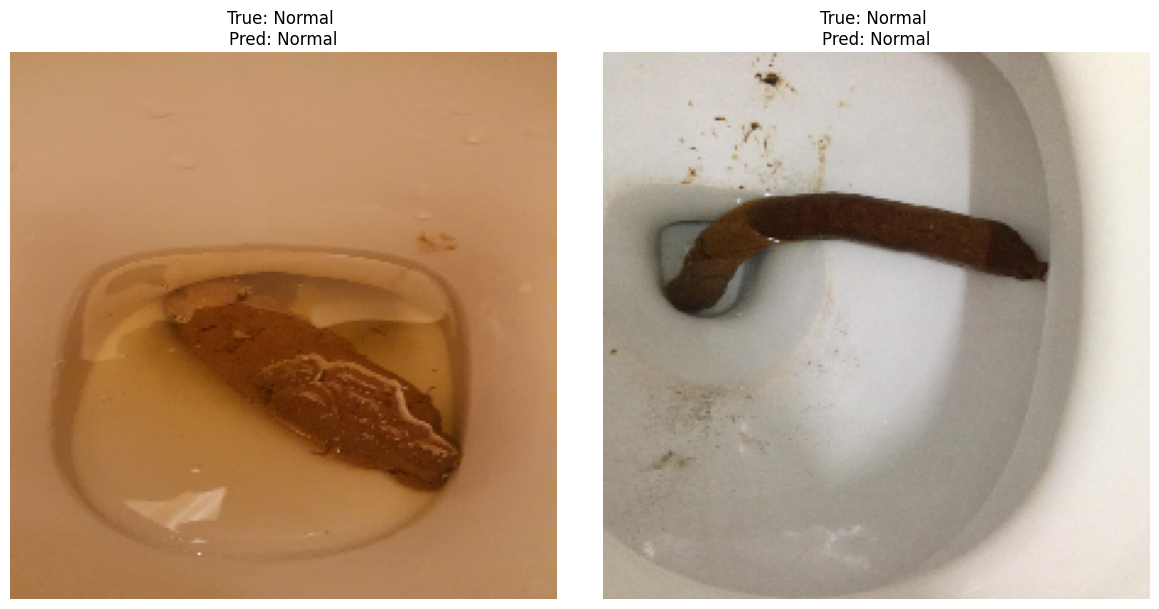

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


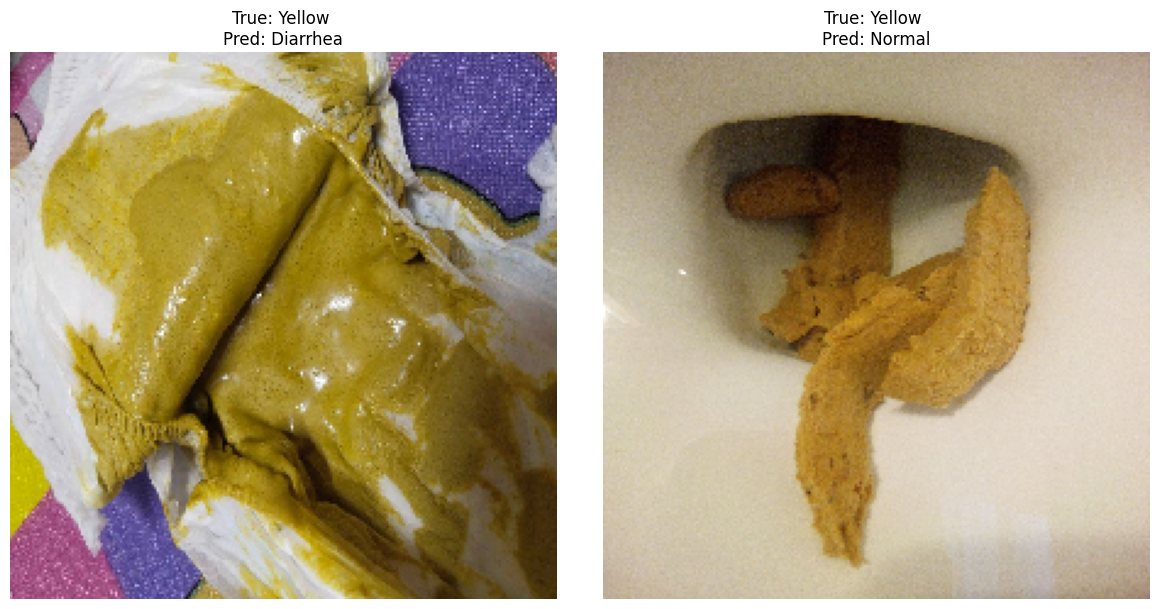

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# จำนวนรูปที่ต้องการสุ่มจากแต่ละคลาส
num_samples = 2

# สุ่มเลือกไฟล์จากแต่ละคลาส
class_names = list(valid_generator.class_indices.keys())  # แปลงเป็น list
for class_name in class_names:
    # กรองไฟล์ที่อยู่ในแต่ละคลาส
    class_files = [file for file in valid_generator.filenames if class_name in file]

    # สุ่มเลือก 2 รูปจากคลาสนี้
    selected_files = random.sample(class_files, num_samples)

    # แสดงรูปที่สุ่มเลือก
    plt.figure(figsize=(12, 6))
    for i, file_name in enumerate(selected_files):
        img_path = os.path.join(valid_generator.directory, file_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = np.array(img) / 255.0

        # ทำนายผล
        y_pred = model.predict(np.expand_dims(img_array, axis=0))
        pred_class = np.argmax(y_pred, axis=1)[0]
        true_class = valid_generator.classes[valid_generator.filenames.index(file_name)]

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_class]} \nPred: {class_names[pred_class]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
